# DEEP PROJECT NOTEBOOK


<!-- Project Description, issues, pictures, present CLIP, TPT, COOP and CoCa briefly. -->
# 1. Project Introduction
Over the last decades Deep Neural Networks have achieved outstanding results in many computer vision applications, such as image classification, object detection, image segmentation, tracking and anomaly detection. However these suffer from a severe performance degradation when tested on images that are of different distribution than the training data. This major issue known as **domain shift**, is a common problem in many real-world applications, such as autonomous driving, medical imaging, and robotics. To address the issue, recent research has studied domain adaptation techniques. These often require access to downstream training data, which is difficult to collect; hence, researchers have focused on **Test-Time Adaptation** (TTA) methods that adapt the pre-trained model to the target domain at test time.

We tested the zero-shot CLIP model by OpenAI [CLIP](https://github.com/openai/CLIP) on the ImageNetA and ImageNetV2 variants and evaluated the Top-1 accuracy of the dataset. Later, we improved it's performance by tuning the prompts with a prompt learner as described by Kaiyang et al. in [Learning to Prompt for Vision-Language Models](https://arxiv.org/pdf/2109.01134), this will be referred to as **Context Optimization (CoOp)**. Then we integrated [Test-Time Prompt Tuning](https://arxiv.org/pdf/2209.07511) proposed by Manli et al. both with and without CoOp. Lastly, our proposed method is an ensamble model of CLIP with CoOp and CoCa, that classifies a batch of image augmentations filtered on the entropy of the predictions. We tried stacking the logits of the filtered images with three different approaches: a standard deviation based approached proposed by Yang. et al. [Image-Caption Encoding for Improving Zero-Shot Generalisation](https://arxiv.org/pdf/2402.02662), a harmonic mean of the logits (ours) and an **entropy-weighted average** of the logits (ours) which achieved a **+2%** improvement in Top-1 accuracy.


# Previous Work
Mention papers we have encountered but discarded... e.g. TTT

## 2. CLIP
<div style="display: flex;">
    <div>
        <p>
        CLIP is a neural network which efficiently learns visual concepts from natural language supervision. CLIP can be applied to any visual classification benchmark by simply providing the names of the visual categories to be recognized, similar to the “zero-shot” capabilities of GPT-2 and GPT-3.
        It is trained on a wide variety of images with a wide variety of natural language supervision that’s abundantly available on the internet. By design, the network can be instructed in natural language to perform a great variety of classification benchmarks, without directly optimizing for the benchmark’s performance.
        </p>
        <p>
        Although both models have the same accuracy on the ImageNet test set, CLIP’s performance is much more representative of how it will fare on datasets that measure accuracy in different, non-ImageNet settings. For instance, ObjectNet checks a model’s ability to recognize objects in many different poses and with many different backgrounds inside homes while ImageNet Rendition and ImageNet Sketch check a model’s ability to recognize more abstract depictions of objects.
        </p>
        <p>
        Source: <a href="https://openai.com/index/clip/">CLIP-OpenAI</a>
        </p>
    </div>
    <div>
        <img src='source/images/CLIP_results.png' width=100%>
    </div>
</div>

### Data Collection
A new dataset, WIT (WebImageText), was created from 400 million (image, text) pairs sourced from the internet, designed to cover a broad range of visual concepts.



### Pre-Training Method
CLIP uses a contrastive objective to learn representations. Referring to the section 1 of figure 3, the loss function is:

$ L_{t2i} = -\frac{1}{N} \sum \limits _{i=1} ^{N} \frac{exp(I_{i} \cdot T_{i}/τ)}{\sum \limits _{k=1} ^{N} exp(I_{k} \cdot T_{i}/τ)} $

$ L_{i2t} = -\frac{1}{N} \sum \limits _{i=1} ^{N} \frac{exp(I_{i} \cdot T_{i}/τ)}{\sum \limits _{k=1} ^{N} exp(I_{i} \cdot T_{k}/τ)} $

$ L = E_{(I_{i}, T_{i}) _{i=1} ^{N}\sim Data}[L_{t2i} + L_{i2t}] $

Unlike previous methods that predict the exact text of captions, CLIP only needs to identify which text matches which image. This method is more scalable and efficient.

<img src='source/images/clip-pretraining.svg' width=60%>

Figure 1. Summary of CLIP approach. While standard image models jointly train an image feature extractor and a linear classifier to predict
some label, CLIP jointly trains an image encoder and a text encoder to predict the correct pairings of a batch of (image, text) training
examples. At test time the learned text encoder synthesizes a zero-shot linear classifier by embedding the names or descriptions of the
target dataset’s classes.


## 3. Model Architecture

CLIP jointly trains an image encoder and a text encoder. The encoders are optimized to maximize the cosine similarity between the correct image-text pairs in a batch. At test time, the text encoder can synthesize a zero-shot classifier by embedding the names or descriptions of target dataset classes.

#### Experiments and Results

CLIP's zero-shot transfer performance was evaluated on over 30 datasets, including tasks such as OCR, action recognition, and fine-grained object classification. CLIP often performed competitively with fully supervised models. Notably, CLIP achieved the same accuracy as ResNet-50 on ImageNet without using any training examples from ImageNet. The study also demonstrates that CLIP is more computationally efficient and robust compared to traditional supervised models.

<img src="source/images/clip-inference.svg" width=60%>

## Test-Time Prompt Tuning (TPT)

Test-Time Prompt Tuning (TPT) is a method proposed to enhance zero-shot generalization capabilities of pre-trained vision-language models, such as CLIP, on new, unseen tasks by dynamically adjusting the text prompts during the test phase. This approach leverages the model's inherent knowledge and adapts it to specific tasks without the need for extra training data or annotations.

## 1. Zero-Shot Generalization:

TPT allows models like CLIP to perform well on new tasks by tuning prompts in real-time based on the input image. It operates in a purely zero-shot manner, thereby enhancing the model's ability to generalize to new domains without additional training or annotations. 
At the inference stage, the only information available is the single test sample $ X_{test} $ without label information. TPT, therefore, manages to optimize the prompt  $ p $ at test time based on the single test sample. In general, our objective can be formulated in the form of 

$  \mathbf{p^∗} = arg min _\mathbf{p} L(F; \mathbf{p}; X_{test}) $

for some carefully constructed loss, where $ \mathbf{p^∗} $ is the optimal prompt distribution. 

## 2. Adaptive Prompt Optimization:

During the test phase, TPT optimizes the text prompt by minimizing the entropy across the outputs of multiple augmented views of a single test image. This ensures consistent predictions across different views, making the model more robust.
We generate N randomly augmented views of the test image using a family of random augmentations $ A $,
and minimize the entropy of the averaged prediction probability distribution:

$ \mathbf{p^∗} = arg min_{\mathbf{p}} − {\sum \limits _{i=1} ^{K}}\tilde{p}_{\mathbf{p}} (y_i|jX_{test}) log \tilde{p}_{\mathbf{p}}(y_i|X_{test}) $

where $ \tilde{p}_{\mathbf{p}}(y_i|X_test) = \frac{1}{N} {\sum \limits _{i=1} ^{N}}p_{\mathbf{p}} (y_i|A_{i}(X_{test})) $

Here,  $ p_{\mathbf{p}}(y_i|A_i(X_{test})) $ is the vector of class probabilities produced by the model when provided with
prompt $ \mathbf{p} $ and the i-th augmented view of the test image.

## 3. Confidence Selection:

TPT incorporates a confidence selection mechanism to filter out noisy augmentations that could lead to inaccurate predictions. Only high-confidence (i.e. with entropy under a certain threshold $ τ $) views are used for prompt optimization, improving the overall reliability of the model's predictions. The benefits of this approach can be observed in Figure 4. (b) of the [TPT paper](https://arxiv.org/pdf/2209.07511).

<img src="source/images/confidence_selection_benefits.png" width=35%> 
<break>
<img src="source/images/confidence_selection_table.png" width=100%>

### Applications

#### 1. Image Classification:

For image classification tasks, TPT generates multiple augmented views of a test image and tunes the prompt to achieve consistent predictions. This improves the zero-shot accuracy of models like CLIP without requiring additional labeled data.
Because labels are not available for test time tuning, the loss for prompt tuning must be unsupervised. The goal is to promote the consistency
of the model’s predictions across different augmented views of a given test image. 

### Benefits

#### 1. Enhanced Generalization:

By tuning prompts dynamically, TPT helps models maintain high performance even when faced with distribution shifts or unseen categories.

#### 2.Improved Performance:

Experimental results have shown that TPT can significantly boost the performance of vision-language models on various benchmarks, achieving state-of-the-art results in many cases.

For more detailed information, you can refer to the original research paper on TPT: [Test-Time Prompt Tuning for Zero-Shot Generalization in Vision-Language Models](https://arxiv.org/pdf/2209.07511).

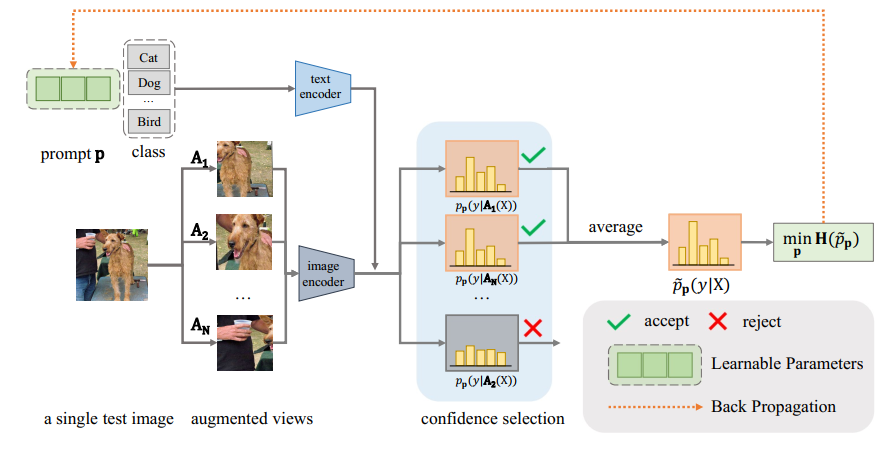

Figure 1: Test-time Prompt Tuning (TPT) for image classification. We tune adaptive prompts on
the fly with a single test sample, without the need for additional training data or annotations. TPT
optimizes the prompt to encourage consistent predictions across augmented views by minimizing the
marginal entropy. We introduce confidence selection to filter out noisy augmentations.

## Context Optimization (CoOp)

Context Optimization (CoOp) is a method designed to enhance vision-language models, such as CLIP, by optimizing textual context in a data-driven manner. This approach circumvents the need for manual prompt tuning by modeling context words with continuous vectors that are learned end-to-end from the data.

<img src='source/images/overview_coop.png' width=70%>

### Key Features
### 1. Unified Context:

CoOp implements two approaches one with the use of a unified context for all classes, sharing the same context tokens across different classes, or a class-specific context, where context vectors are independent to each class. In our project we used the former, **unified context**. The prompt given to the text encoder is represented as:

$ t = [V]_1[V]_2...[V]_M[CLASS]$

Here, $ [V]_m $ are learnable vectors representing context tokens, $ M $ is a hyperparameter specifying the number of context tokens and  $ [CLASS] $ is a placeholder for the class name.
The context tokens ( $ [V]_m $ ) are continuous vectors with the same dimension as word embeddings (e.g., 512 for CLIP), allowing them to be optimized during training.


### 2. End-to-End Learning:

CoOp optimizes these context tokens in an end-to-end manner, leveraging the model's pre-trained knowledge without modifying the pre-trained parameters.

### 3. Prediction Probability:

The prediction probability for an image $ x $ belonging to class $ i $ is computed as:

$ p(y=i|\mathbf{x}) = \frac{exp(cos(\mathbf{w_i},\mathbf{f}/τ))}{\sum \limits _{j=1} ^{K}exp(cos(\mathbf{w_j},\mathbf{f}/τ))} $ 
 
where $ τ $ is a temperature parameter, $ cos(⋅,⋅) $ denotes cosine similarity, $ f $ represents the image features and $ w_i $ are the weight vectors generated by the text encoder.

### 4. Optimization Objective:

The objective of CoOp is to minimize the cross-entropy loss ( $ L = -\Sigma_{x,y \in D} log(p(x|y)) $ ) over the training data, updating the context tokens to improve performance

### Performance and Results
The authors of CoOp present the following table of results.

As the table shows the overall performance of models using CoOp increases

<img src='source/images/coop_comparisons_table.png' width=50%>

### 1. Few-Shot Learning:

CoOp significantly improves few-shot learning performance. For instance, with ResNet-50, CoOp achieves 63.33% accuracy on ImageNet with 4 shots, compared to 58.18% for zero-shot CLIP.

### 2. Domain Generalization:

CoOp demonstrates robust performance across various datasets, showing resilience to distribution shifts. On the DOSCO-2k benchmark, CoOp outperforms zero-shot CLIP in most cases, indicating its robustness and adaptability.

### 3. Broad Applicability:

CoOp performs well in a variety of tasks, including generic object recognition (ImageNet, Caltech101), fine-grained recognition (aircraft models, textures), and action recognition (UCF101).

### Conclusion
CoOp represents a significant advancement in enhancing vision-language models' performance, particularly in few-shot learning scenarios. By optimizing context tokens in a data-driven manner, CoOp leverages pre-trained knowledge effectively, achieving state-of-the-art results without additional manual tuning. This approach is highly adaptable, showing robust performance across different datasets and tasks, making it a powerful tool for vision-language integration in diverse applications.

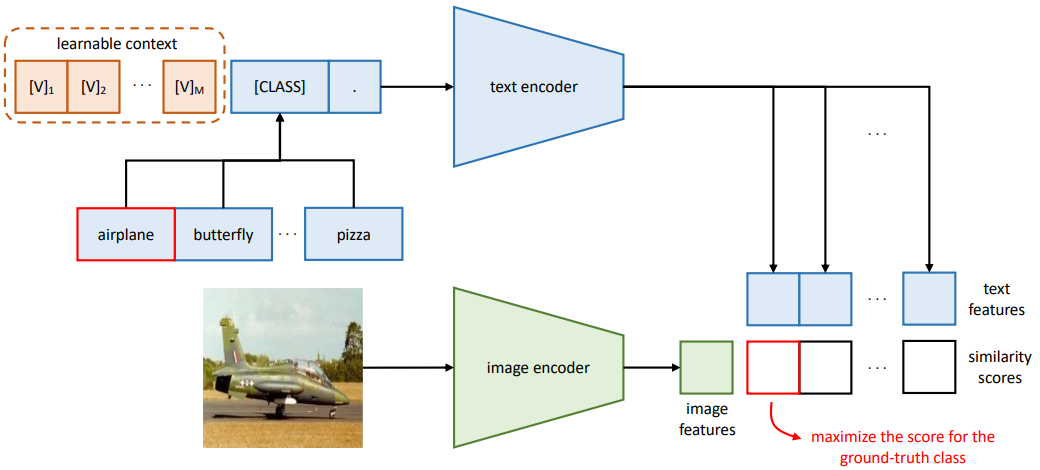

Figure 2: Overview of Context Optimization (CoOp). The main idea is to model a prompt’s context using a set of learnable
vectors, which can be optimized through minimizing the classification loss. Two designs are proposed: one is unified context,
which shares the same context vectors with all classes; and the other is class-specific context, which learns for each class a
specific set of context vectors.

## CoCa (Contrastive Captioner)

CoCa focuses on pretraining image-text foundation models for computer vision tasks. It is a minimalist model that merges the capabilities of contrastive approaches (like CLIP) and generative methods (like SimVLM). CoCa's design includes an image-text encoder-decoder framework optimized with both contrastive loss and captioning loss, facilitating efficient computation and high performance in various tasks.

### Introduction

The goal of CoCa is to unify different paradigms, such as single-encoder models focusing on image classification, dual-encoder models leveraging contrastive loss for image-text pairs, and encoder-decoder models for generative pretraining, into a single model that can efficiently handle both vision and vision-language tasks.

<img src='source/images/coca_fig1.png' width=80%>

Figure 4: Overview of Contrastive Captioners (CoCa) pretraining as image-text foundation models.
The pretrained CoCa can be used for downstream tasks including visual recognition, vision-language
alignment, image captioning and multimodal understanding with zero-shot transfer, frozen-feature
evaluation or end-to-end finetuning

### Model Architecture and Objectives

CoCa's architecture includes:

- Image Encoder: Transforms images into latent representations.
- Text Decoder: Split into two parts—unimodal and multimodal. The unimodal decoder layers process text independently, while the multimodal layers integrate image features through cross-attention.
- Contrastive Loss: Applied between unimodal image and text embeddings to align their representations.
- Captioning Loss: Applied to the outputs of the multimodal decoder to predict text tokens autoregressively.

<img src='source/images/coca_fig2.png' width=70%>

Figure 5: Detailed illustration of CoCa architecture. A simple encoder-decoder approach that seamlessly combines the three training paradigms




Similar to standard image-text encoderdecoder models, CoCa encodes images to latent representations by a neural network encoder, for
example, vision transformer (ViT), and decodes texts with a causal masking transformer decoder. Unlike standard decoder transformers, CoCa omits cross-attention in the first half of the decoder layers to encode unimodal text representations, and cascades the rest of the decoder layers, cross-attending to the image encoder for multimodal image-text representations. As a result, the CoCa decoder simultaneously produces both unimodal and multimodal text representations that allow us to apply both contrastive and generative objectives:

$ L_{CoCa} = λ_{Con} · L_{Con} + λ_{Cap} · L_{Cap} $

where $ λ_{Con} $ and $ λ_{Cap} $ are loss weighting hyper-parameters, $ L_{Con} $ is the Dual-Encoder Contrastive Learning loss and $ L_{Cap} $ is the Encoder-Decoder Captioning loss.

### Pretraining Approach

CoCa is pretrained on both web-scale alt-text data and annotated images, treating all labels as text. This unified approach leverages natural language supervision for comprehensive representation learning.

### Performance and Results
CoCa demonstrates state-of-the-art performance across a range of tasks, including:

- Visual Recognition: Achieves 86.3% zero-shot top-1 accuracy on ImageNet and 91.0% with fine-tuning.
- Crossmodal Retrieval: Excels in tasks like MSCOCO and Flickr30K retrieval.
- Multimodal Understanding: Shows strong results in VQA, SNLI-VE, and NLVR2.
- Image Captioning: Performs well on datasets like MSCOCO and NoCaps.

### Methodology
CoCa's training involves a single stage that integrates contrastive learning and captioning. The model's architecture enables efficient computation and effective learning of both unimodal and multimodal representations.

### Conclusion

CoCa sets a new benchmark in image-text pretraining by combining contrastive and generative objectives in a streamlined architecture. Its versatility and high performance across various tasks highlight the potential of unified pretraining models in advancing computer vision and vision-language understanding.

## Our Approach
We propose an ensemble model that combines the strengths of the afore mentioned methods with the additional contribution of CoCa. Given an image we generate a set of augmentations and filter them based on the entropy of the predictions. We then generate captions corresponding to the filtered images using [CoCa](https://arxiv.org/abs/2205.01917) (Contrastive Captioner) and stack the logits of the filtered images. After doing so we apply the TPT step and minimise the entropy of the stacked logits. After backpropagatin we generate a final prediction and reset the network and the optimizer.

### 1. Image Augmentations
We generate a set of augmentations for each image in the batch. We augment the images using [augmix](https://arxiv.org/abs/1912.02781) and then randomly choose from horizontal flip, random vertical flip and random crop augmentations to apply again.

### 2. Filtering
We filter the images based on the entropy of the predictions. We only keep the **10th percentile** of the images with the lowest entropy according to the ablation study in **TPT**.

### 3. Caption Generation
We generate captions for the filtered images using CoCa which is a pretrained model that generates captions for images using a contrastive loss. The captions generated by CoCa provide a more detailed and informative description of the content of the image, often capturing fine-grained details and multiple objects present in the image. We then work out the similarity between the captions and the prompt plus the class names. A first attempt leveraged the CLIP text encoder to determine a similarity score but this failed to grasp similarity between **hypernyms** and **hyponyms** e.g. between 'dog' and 'pug'. Hence we employed the text encoder from CoCa which was able to better recognise these relationships.

The choice of using CoCa was related to memory constraints and to provide greater similarity between the underlying backbones and architectures involved in the classification pipeline. However, future work could leverage other captioning models such as [LLava](https://arxiv.org/abs/2304.08485), [BLIP](https://arxiv.org/abs/2201.12086) or the more recent [BLIP-2](https://arxiv.org/abs/2301.12597).

### 4. Stacking
To stack the logits we tried three different approaches: a standard deviation based approach proposed by Yang. et al. [Image-Caption Encoding for Improving Zero-Shot Generalisation](https://arxiv.org/pdf/2402.02662), a harmonic mean of the logits (ours) and an **entropy-weighted average** of the logits (ours).

Let $f$ be the logits of the CLIP model, $f_{caption}$ be the logits of the CoCa model, $\sigma$ be the standard deviation, $H$ be the entropy and $\alpha$ be a normalising weight.

The first approach calculates the standard deviation of the caption logits and then adds a re-weighted version of the caption logits to the clip logits.

$ f = f + \alpha \cdot \sigma(f_{caption}) \cdot f_{caption} $

The second approach calculates the harmonic mean of the two logits. However this approach has shown to be less effective than the other two as the ensemble is suppose to combine the strengths of the two models to compensate for each other weaknesses, whereas the harmonic punishes discrepancy between the two models which is when our approach tries to be most effective.

$ f = \frac{2 \cdot f \cdot f_{caption}}{f + f_{caption}} $

The third approach calculates the entropy of the caption logits and CLIP logits and then calculates the weighted average of the two logits based on the entropy of the caption logits.

$ A = \frac{1}{1 + H({f})} $ Weight for CLIP logits

$ B = \frac{1}{1 + H({f_{caption}})} $ Weight for caption logits

$ C = A + B $ Normalising factor for the two weights

$ f = \frac{A}{C} f + \frac{B}{C}f_{caption} $ Weighted average of the two logits


### Model Architecture and Objectives

CoCa's architecture includes:

- Image Encoder: Transforms images into latent representations.
- Text Decoder: Split into two parts—unimodal and multimodal. The unimodal decoder layers process text independently, while the multimodal layers integrate image features through cross-attention.
- Contrastive Loss: Applied between unimodal image and text embeddings to align their representations.
- Captioning Loss: Applied to the outputs of the multimodal decoder to predict text tokens autoregressively.

## Project Setup

To run this notebook, you need to install the required dependencies. You can do this by running the following commands in your terminal:

Step 1

Download project libraries

Step 2

Import libraries

Step 3

Download resources:
- ImageNetA
- ImageNetV2
- CoOp pretrained weights

In [13]:
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux

In [2]:
%cd DS-DLProject

/content/DS-DLProject


In [3]:
import gdown
import io
import numpy as np
import os
import requests
import sys
import tarfile
import torch, torchvision
torchvision.disable_beta_transforms_warning()
import torch.amp
import torchvision.transforms as transforms
import zipfile
from torch.utils.tensorboard import SummaryWriter

from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

from CLIP import clip

from COOP.models import OurCLIP
from COOP.utils import get_optimizer, get_loss_function, log_values
from COOP.functions import training_step, test_step
from COOP.dataloader import get_data
from loaders import Augmixer
from utils import entropy, batch_report, make_histogram
from copy import deepcopy
from open_clip import factory

DEBUG = True

Here we download the imagenet-a and imagenetV2 dataset

In [4]:
# Define the URL for the ImageNet-A dataset
url_a = "https://people.eecs.berkeley.edu/~hendrycks/imagenet-a.tar"
url_v2 = "https://huggingface.co/datasets/vaishaal/ImageNetV2/resolve/main/imagenetv2-matched-frequency.tar.gz"

# Define the local filename to save the dataset
local_filename_a = "imagenet-a.tar"
local_filename_v2 = "imagenetv2-matched-frequency-format-val.tar"

# download a file from a URL
def download_file(url, local_filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

def extract_tar_file(file_name, output_dir='.'):
    with tarfile.open(file_name, 'r') as tar:
        tar.extractall(path=output_dir)

# Download the imagenet-a dataset
download_file(url_a, local_filename_a)

extract_tar_file(local_filename_a, './data')

# Download the imagenet-v2 dataset
download_file(url_v2, local_filename_v2)

extract_tar_file(local_filename_v2, './data')

# Clean up the tar files
os.remove(local_filename_a)
os.remove(local_filename_v2)

print("Download and extraction complete.")

Download and extraction complete.


We download the four backbones of COOP

In [5]:
# Create a directory
output_dir = './bin/coop'
os.makedirs(output_dir, exist_ok=True)

# Download the models from the link given in the original github repository
url = 'https://drive.google.com/uc?id=18ypxfd82RR0pizc5MM1ZWDYDk4j0BtPF'
output_file = os.path.join(output_dir, 'backbones_COOP.zip')
gdown.download(url, output_file, quiet=False)

# Path to the downloaded zip file
zip_file = os.path.join(output_dir, 'backbones_COOP.zip')

# Extract the contents
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

os.remove(zip_file)


Downloading...
From (original): https://drive.google.com/uc?id=18ypxfd82RR0pizc5MM1ZWDYDk4j0BtPF
From (redirected): https://drive.google.com/uc?id=18ypxfd82RR0pizc5MM1ZWDYDk4j0BtPF&confirm=t&uuid=56dae334-0b34-410e-9406-3d24acd4e34e
To: /content/DS-DLProject/bin/coop/backbones_COOP.zip
100%|██████████| 137M/137M [00:04<00:00, 30.2MB/s]


In [10]:
%mv bin/coop/to_gdrive/* bin/coop/
%rmdir bin/coop/to_gdrive/
%ls bin/coop

rn101_ep50_16shots/  rn50_ep50_16shots/  vit_b16_ep50_16shots/  vit_b32_ep50_16shots/


# Implementation Details


The whole project is built on top of the <cite>tpt_eval.py</cite> file. The file is structured in order to make the main required imports and it implements the **Test Time Adaptation** step. There are two main functions:
1. tta_net_train 
2. tpt_train_loop

In order to guide the update step which perform gradient descent to update the prompt lerner parameters, we use _avg_entropy_ as loss function as shown in [Test-Time Prompt Tuning for Zero-Shot Generalization in Vision-Language Models](https://arxiv.org/pdf/2209.07511).

In [ ]:
def avg_entropy(outputs):
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True) # logits = outputs.log_softmax(dim=1) [N, 1000]
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0]) # avg_logits = logits.mean(0) [1, 1000]
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

As optimizer we use AdamW. We easily get it from torch library. We will set the learning rate at 0.005, as done in the TPT paper provided before.

In [ ]:
def get_optimizer(params, lr):
    optimizer = torch.optim.AdamW(params, lr)
    return optimizer

_tta_net_train_: is used to update the network weights according to the average entropy of the logits which comes from the network. 

In [ ]:
def tta_net_train(batch, net, optimizer, scaler, id2classes, device="cuda", captioner=None, debug=False):
    batch_idx, inputs, targets = batch

    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs, text_features = net(inputs)
    outputs = outputs.softmax(dim=-1)

    filtered_inputs, filtered_outputs = filter_on_entropy(inputs, outputs, p_percentile=10, return_original=debug)
    if captioner is not None:
        batch = (batch_idx, filtered_inputs, filtered_outputs, targets)
        filtered_outputs = add_caption_loss(net, captioner, batch, text_features, id2classes, debug=debug, ensamble_method=ENSAMBLE_METHOD)

    avg_predictions = torch.mean(filtered_outputs, dim=0).unsqueeze(0)
    prediction_entropy = entropy(avg_predictions).item()

    optimizer.zero_grad()
    loss = avg_entropy(filtered_outputs)

    if scaler is None:        
        loss.backward()
        optimizer.step()
    else:
        with torch.cuda.amp.autocast():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    # show batch
    if batch_idx % LOG_FREQUENCY == 0:
        batch_report(filtered_inputs, filtered_outputs, avg_predictions, targets, id2classes, batch_n=batch_idx)
        
    prediction = avg_predictions.argmax(dim=1)
    return loss.item(), prediction, prediction_entropy


_tpt_train_loop_: is the main function which takes every element of the dataset, updates the network calling _tta_net_train_, evaluate the prediction with the new network and then it resets the network for the next sample.

In [ ]:
def tpt_train_loop(data_loader, net, optimizer, cost_function, scaler, writer, id2classes, device="cuda", captioner=None, debug=False, checkpoint=None):
    
    if checkpoint:
        offset, cumulative_loss, top1, top5, no_tpt_class_acc, tpt_class_acc = checkpoint
    else:
        offset = 0
        cumulative_loss = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()

        no_tpt_class_acc = {c: AverageMeter() for c in id2classes.values()}
        tpt_class_acc = {c: AverageMeter() for c in id2classes.values()}
    
    loss_diff = 0.0
    optimizer_state = deepcopy(optimizer.state_dict())

    try:
        pbar = tqdm(data_loader, desc="Testing", position=0, leave=True, initial=offset, total=len(data_loader)+offset)
        for batch_idx, (inputs, targets, _) in enumerate(data_loader):
            batch_idx += offset # offset to continue from a checkpoint

            # Reset the prompt_learner to its initial state and the optimizer to its initial state
            with torch.no_grad():
                net.reset()
                optimizer.load_state_dict(optimizer_state)

            _loss, no_tpt_prediction, no_tpt_prediction_entropy = tta_net_train((batch_idx, inputs, targets), net, optimizer, scaler, id2classes, device=device, captioner=captioner, debug=debug)

            net.eval()
            with torch.no_grad():
                # Classification with the updated net
                inputs = inputs[0].unsqueeze(0).to(device)
                targets = targets.to(device)
                outputs, _ = net(inputs)
                loss = cost_function(outputs, targets)
                prediction = outputs.argmax(dim=1)
                prediction_entropy = entropy(prediction).item()

                cumulative_loss.update(loss.item())

            # Update accuracies
            _key = id2classes[targets.item()]
            if no_tpt_prediction.item() == targets.item():
                no_tpt_class_acc[_key].update(1)
            else:
                no_tpt_class_acc[_key].update(0)

            values, predictions = outputs.topk(5)
            if prediction == targets:
                top1.update(1)
                tpt_class_acc[_key].update(1)
            else:
                top1.update(0)
                tpt_class_acc[_key].update(0)

            if targets.item() in predictions:
                top5.update(1)
            else:
                top5.update(0)

            loss_diff =  _loss - loss.item() # comparison of loss with and without TPT
            entropy_diff = prediction_entropy - no_tpt_prediction_entropy # comparison of entropy with and without TPT
            # Log Values
            writer.add_scalar("Delta_loss/test", loss_diff, batch_idx)
            writer.add_scalar("Delta_entropy/test", entropy_diff, batch_idx)
            writer.add_scalar("Top-1", top1.get_avg(), batch_idx)
            writer.add_scalar("Top-5", top5.get_avg(), batch_idx)

            if batch_idx % LOG_FREQUENCY == 0 :#and batch_idx > 10:
                logger.info(f"[LOSS] Batch {batch_idx} - Delta loss: {loss_diff:.5f}, Delta entropy: {entropy_diff:.5f}")
                no_tpt_accuracies, accuracies = compute_accuracies(no_tpt_class_acc, tpt_class_acc)
                histogram = make_histogram(no_tpt_accuracies, accuracies, 
                                        'No TPT', 'TPT', save_path=f"runs/{RUN_NAME}/class_accuracy%{batch_idx}e.png")
                writer.add_image(f"Class accuracies%{batch_idx}e", histogram, batch_idx, dataformats="HWC")
                logger.info(f"[ACC] Batch num:{batch_idx} - Top1: {top1.get_avg()}, Top5: {top5.get_avg()}")

                dump_object = batch_idx, cumulative_loss, top1, top5, no_tpt_class_acc, tpt_class_acc
                pickle.dump(dump_object, open(f"runs/{RUN_NAME}/checkpoint%{batch_idx}.pkl", "wb"))
            
            
            pbar.set_postfix(test_loss=loss.item(), top1=top1.get_avg(), top5=top5.get_avg())
            pbar.update(1)

    except KeyboardInterrupt:
        print("User keyboard interrupt")
    if batch_idx % LOG_FREQUENCY != 0 or batch_idx == len(data_loader) + offset:#and batch_idx > 10:
        logger.info(f"[LOSS] Batch {batch_idx} - Delta loss: {loss_diff:.5f}, Delta entropy: {entropy_diff:.5f}")
        no_tpt_accuracies, accuracies = compute_accuracies(no_tpt_class_acc, tpt_class_acc)
        histogram = make_histogram(no_tpt_accuracies, accuracies, 
                                'No TPT', 'TPT', save_path=f"runs/{RUN_NAME}/class_accuracy%{batch_idx}e.png")
        writer.add_image(f"Class accuracies%{batch_idx}e", histogram, batch_idx, dataformats="HWC")
        logger.info(f"[ACC] Batch num:{batch_idx} - Top1: {top1.get_avg()}, Top5: {top5.get_avg()}")

        dump_object = batch_idx, cumulative_loss, top1, top5, no_tpt_class_acc, tpt_class_acc
        pickle.dump(dump_object, open(f"runs/{RUN_NAME}/checkpoint%{batch_idx}.pkl", "wb"))

    # Draw histogram of class accuracies
    no_tpt_accuracies, accuracies = compute_accuracies(no_tpt_class_acc, tpt_class_acc)
    image = make_histogram(no_tpt_accuracies, accuracies, 'No TPT','TPT', save_path=f"runs/{RUN_NAME}/accuracy_by_class.png")
    image = make_histogram(no_tpt_accuracies, accuracies, 'No TPT','TPT', save_path=f"runs/{RUN_NAME}/accuracy_by_worst_class.png", worst_case=True)
    
    writer.add_image("Class accuracies", image, 0, dataformats="HWC")

    return cumulative_loss.get_avg() , top1.get_avg()
    

We create the class AugmixFolder

In [ ]:
class AugmixFolder(datasets.ImageFolder):
    def __init__(self, root,transform):
        super(AugmixFolder, self).__init__(root, transform=transform)
        self.transform = transform
        
    def __getitem__(self, index):
        img, label = super(AugmixFolder, self).__getitem__(index)
        path = self.imgs[index][0]
        if isinstance(self.transform, Augmixer):
            return img.squeeze(0), label, path
        return img, label, path

We define a function to retrieve the data we downloaded before 

In [ ]:
def get_data(dataset_name, batch_size, transform, shuffle=True, train_size=0.8, val_size=0.1, from_idx=0):
    """
    Loads the dataset and splits it into training, validation and test sets. Available datsets:
    ["cifar10", "cifar100", "imagenet_v2", "imagenet_a"]
    :param dataset_name: str: name of the dataset
    :param batch_size: int: batch size
    :param transform: function: preprocessing function
    :param shuffle: bool: shuffle the dataset
    :param train_size: float: proportion of the dataset to include in the training set
    :param val_size: float: proportion of the dataset to include in the validation set
    :return: tuple: training, validation and test dataloaders
    """
    if dataset_name == "cifar10":
        download = not (os.path.exists(os.path.join("data/cifar-10-python")))
        dataset = AugmixFolder(root="./data", download=download, transform=transform)
        id2class = {dataset.class_to_idx[c] : c for c in dataset.classes}
    elif dataset_name == "cifar100":
        download = not (os.path.exists(os.path.join("data/cifar-100-python")))
        dataset = AugmixFolder(root="./data", download=download, transform=transform)
        id2class = {dataset.class_to_idx[c] : c for c in dataset.classes}
    elif dataset_name == "imagenet_v2":
        dataset = AugmixFolder(root="./data/imagenetv2-matched-frequency-format-val", transform=transform)
        dataset.class_to_idx = {cls: i for i, cls in enumerate(dataset.classes)}
        id2class = {dataset.class_to_idx[c] : py_vars.num2class_v2[int(c)] for c in dataset.classes}
    elif dataset_name == "imagenet_a":
        dataset = AugmixFolder(root="./data/imagenet-a", transform=transform)
        dataset.class_to_idx = {cls: i for i, cls in enumerate(dataset.classes)}
        id2class = {dataset.class_to_idx[c] : py_vars.num2class[c] for c in dataset.classes}
    else:
        raise ValueError(f"Unknown dataset {dataset_name}")
    
    n = len(dataset)
    n_train = int(train_size * n)
    n_val = int(val_size * n)
    n_test = n - n_train - n_val
    
    if(n_train + n_val == 0):
        train_loader, val_loader = None, None
        if batch_size == 1:
            test_loader = data.DataLoader(dataset, batch_size=batch_size, 
                                          sampler=CustomSampler(range(n), from_idx=from_idx), collate_fn=my_collate)
        else:
            test_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                                          sampler=CustomSampler(range(n), from_idx=from_idx))
    else:
        train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train, n_val, n_test])

        train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=my_collate)
        val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=my_collate)
        test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=my_collate)

    return train_loader, val_loader, test_loader, list(id2class.values()), id2class

In the main we load and augment the data, we load CLIP and COOP. We use AdamW as optimizer

In [ ]:
def main(
    dataset_name="imagenet_a",
    backbone="ViT-B/16",
    device="mps",
    batch_size=64,
    learning_rate=0.005,
    run_name=RUN_NAME,
    n_ctx=4,
    ctx_init="a_photo_of_a",
    class_token_position="end",
    csc=False,
    ice_loss=True,
    debug=DEBUG
):
    DEBUG = debug
    RUN_NAME = run_name

    checkpoints = [file for file in os.listdir(f"runs/{RUN_NAME}") if file.startswith("checkpoint")]
    if len(checkpoints) > 0:
        files = sorted(checkpoints,
                        key=lambda x: int(x.split("%")[1].split(".")[0]),
                        reverse=True)
        checkpoint = pickle.load(open(f"runs/{RUN_NAME}/{files[0]}", "rb"))
        from_idx = checkpoint[0]
    else:
        checkpoint = None
        from_idx = 0

    seed = 0
    print("Using manual seed {}".format(seed))
    torch.manual_seed(seed)
    # Create a logger for the experiment
    run_name = RUN_NAME
    writer = SummaryWriter(log_dir=f"runs/{run_name}")

    _, preprocess = clip.load(backbone, device=device)
    
    data_transform = Augmixer(preprocess, batch_size, augmix=True, severity=1)
    # Get dataloaders
    _, _, test_loader, classnames, id2class = get_data(
        dataset_name, 1, data_transform, train_size=0, val_size=0, from_idx=from_idx
    )    

    # Instantiate the network and move it to the chosen device (GPU)
    net = OurCLIP(
        classnames=classnames,
        n_ctx=n_ctx,
        ctx_init=ctx_init,
        class_token_position=class_token_position,
        backbone=backbone,
        csc=csc,
    ).to(device)

    load_pretrained_coop(backbone, net, device)

    print("Turning off gradients in both the image and the text encoder")
    for name, param in net.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)

    print(f"Total parameters: {sum(p.numel() for p in net.parameters()):,}")
    print(
        f"Total trainable parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}"
    )

    trainable_param = net.prompt_learner.parameters()
    optimizer = get_optimizer(trainable_param, learning_rate)

    cost_function = get_loss_function()

    if device == 'cuda':
        scaler = torch.cuda.amp.GradScaler(init_scale=1000)
    else:
        scaler = None

    # Instantiate the captioner if needed
    captioner = None
    if ice_loss:
        model_name = "coca_ViT-L-14"
        version = "laion2B-s13B-b90k"
        captioner = Captioner(model_name=model_name, version=version, device=device)

    print(f"Beginning testing with TPT + ice_loss={ice_loss}:")
    test_loss, test_accuracy = tpt_train_loop(test_loader, net, optimizer, cost_function, scaler, writer, id2classes=id2class, device=device, captioner=captioner, debug=debug, checkpoint=checkpoint)
    print(f"\tTest loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}")
    
    create_run_info(dataset_name, backbone, ice_loss, test_accuracy, run_name, ENSAMBLE_METHOD)
    
    writer.close()